In [1]:
import pickle as pkl
import pandas as pd 
import numpy as np
from tqdm import tqdm 
from rdkit.Chem import MolFromSmiles, rdFingerprintGenerator, MolToInchiKey, RemoveHs, AtomValenceException, Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from rdkit.DataStructs import TanimotoSimilarity, ExplicitBitVect
from rdkit.Chem import MolToMolBlock
from rdkit.Chem import SanitizeMol
from rdkit.Chem import MolToSmiles
from rdkit.Chem import MolFromSmarts, ReplaceSubstructs
from rdkit import Chem
from PIL import Image, ImageChops
from rdkit.Chem import Draw
from PIL import Image, ImageDraw, ImageFont
np.random.seed(seed=42)

In [2]:
with open('../data/neims/spec_files/df_neims_gecko_3_9_22.pkl', 'rb') as file:
    df1 = pkl.load(file)
print(df1.shape)
df1.head(4)

(166158, 2)


,SMILES,spec
0,C=O,"[[14, 202], [15, 313], [16, 165], [18, 16], [1..."
1,O=C[N+](=O)[O-],"[[14, 72], [16, 151], [17, 70], [18, 108], [19..."
2,O=CC(=O)[N+](=O)[O-],"[[14, 153], [15, 174], [16, 125], [17, 36], [1..."
3,O=C(O)C(=O)[N+](=O)[O-],"[[14, 120], [15, 236], [16, 149], [17, 78], [1..."


In [3]:
df2 = pd.read_csv('../data/neims/labels.tsv', sep='\t')
df2['key'] = df2['spec']
df2 = df2.drop(columns='spec')
print(df2.shape)
df2.head(4)

(166158, 8)


,Unnamed: 0,dataset,ionization,formula,smiles,inchikey,instrument,key
0,0,neims,[M]+,CH2O,C=O,WSFSSNUMVMOOMR-UHFFFAOYSA-N,simulated,gecko_0
1,1,neims,[M]+,CHNO3,O=C[N+](=O)[O-],CAMJPMYWRKKZNK-UHFFFAOYSA-N,simulated,gecko_1
2,2,neims,[M]+,C2HNO4,O=CC(=O)[N+](=O)[O-],UJDBJZXDOVXPFV-UHFFFAOYSA-N,simulated,gecko_2
3,3,neims,[M]+,C2HNO5,O=C(O)C(=O)[N+](=O)[O-],RMULBIRLFFXIEL-UHFFFAOYSA-N,simulated,gecko_3


In [4]:
df1['mol'] = df1['SMILES'].apply(MolFromSmiles)
df1['inchikey'] = df1['mol'].apply(MolToInchiKey)
print(df1.shape)
df1.head(4)

(166158, 4)


,SMILES,spec,mol,inchikey
0,C=O,"[[14, 202], [15, 313], [16, 165], [18, 16], [1...",<rdkit.Chem.rdchem.Mol object at 0x00000260401...,WSFSSNUMVMOOMR-UHFFFAOYSA-N
1,O=C[N+](=O)[O-],"[[14, 72], [16, 151], [17, 70], [18, 108], [19...",<rdkit.Chem.rdchem.Mol object at 0x00000260403...,CAMJPMYWRKKZNK-UHFFFAOYSA-N
2,O=CC(=O)[N+](=O)[O-],"[[14, 153], [15, 174], [16, 125], [17, 36], [1...",<rdkit.Chem.rdchem.Mol object at 0x00000260403...,UJDBJZXDOVXPFV-UHFFFAOYSA-N
3,O=C(O)C(=O)[N+](=O)[O-],"[[14, 120], [15, 236], [16, 149], [17, 78], [1...",<rdkit.Chem.rdchem.Mol object at 0x00000260403...,RMULBIRLFFXIEL-UHFFFAOYSA-N


In [5]:
df = pd.merge(df1, df2, on='inchikey')
print(df.shape)
df.head(4)

(166158, 11)


,SMILES,spec,mol,inchikey,Unnamed: 0,dataset,ionization,formula,smiles,instrument,key
0,C=O,"[[14, 202], [15, 313], [16, 165], [18, 16], [1...",<rdkit.Chem.rdchem.Mol object at 0x00000260401...,WSFSSNUMVMOOMR-UHFFFAOYSA-N,0,neims,[M]+,CH2O,C=O,simulated,gecko_0
1,O=C[N+](=O)[O-],"[[14, 72], [16, 151], [17, 70], [18, 108], [19...",<rdkit.Chem.rdchem.Mol object at 0x00000260403...,CAMJPMYWRKKZNK-UHFFFAOYSA-N,1,neims,[M]+,CHNO3,O=C[N+](=O)[O-],simulated,gecko_1
2,O=CC(=O)[N+](=O)[O-],"[[14, 153], [15, 174], [16, 125], [17, 36], [1...",<rdkit.Chem.rdchem.Mol object at 0x00000260403...,UJDBJZXDOVXPFV-UHFFFAOYSA-N,2,neims,[M]+,C2HNO4,O=CC(=O)[N+](=O)[O-],simulated,gecko_2
3,O=C(O)C(=O)[N+](=O)[O-],"[[14, 120], [15, 236], [16, 149], [17, 78], [1...",<rdkit.Chem.rdchem.Mol object at 0x00000260403...,RMULBIRLFFXIEL-UHFFFAOYSA-N,3,neims,[M]+,C2HNO5,O=C(O)C(=O)[N+](=O)[O-],simulated,gecko_3


In [6]:
test_names = pd.read_csv('batch_names.txt', index_col=None, header=None).values.flatten()
test_names

array(['gecko_112646', 'gecko_18037', 'gecko_133667', ..., 'gecko_54476',
       'gecko_152305', 'gecko_134980'], dtype=object)

In [7]:
df_test = df[df['key'].isin(test_names)].set_index('key').loc[test_names].reset_index()
df_test = df_test.reset_index().drop(columns='index')
print(df_test.shape)
df_test.head(4)

(1024, 11)


,key,SMILES,spec,mol,inchikey,Unnamed: 0,dataset,ionization,formula,smiles,instrument
0,gecko_112646,CC(=O)C1OOC(C(O)(C(=O)OO[N+](=O)[O-])[N+](=O)[...,"[[14, 37], [15, 48], [16, 21], [17, 7], [18, 2...",<rdkit.Chem.rdchem.Mol object at 0x000002603FD...,UVQLIRPGVOIFEW-UHFFFAOYSA-N,112551,neims,[M]+,C7H8N2O12,CC(=O)C1OOC(C(O)(C(=O)OO[N+](=O)[O-])[N+](=O)[...,simulated
1,gecko_18037,O=CC(O)(C=O)C(=O)OC(OO)C(=O)O,"[[14, 125], [15, 288], [16, 161], [17, 198], [...",<rdkit.Chem.rdchem.Mol object at 0x00000260384...,RDZVAHAQASSBEZ-UHFFFAOYSA-N,18030,neims,[M]+,C6H6O9,O=CC(O)(C=O)C(=O)OC(OO)C(=O)O,simulated
2,gecko_133667,CC(O)(C(=O)O)C(C=O)O[N+](=O)[O-],"[[14, 102], [15, 219], [16, 100], [17, 95], [1...",<rdkit.Chem.rdchem.Mol object at 0x00000260A32...,BKMGPEJZVSJROT-UHFFFAOYSA-N,133515,neims,[M]+,C5H7NO7,CC(O)(C(=O)O)C(C=O)O[N+](=O)[O-],simulated
3,gecko_42648,O=CC(O)C(O[N+](=O)[O-])C(=O)OC(C=O)(OO)C(=O)OO...,"[[14, 59], [15, 105], [16, 115], [17, 33], [18...",<rdkit.Chem.rdchem.Mol object at 0x000002603E8...,JZLREPANYJWLEW-UHFFFAOYSA-N,42616,neims,[M]+,C7H6N2O15,O=CC(O)C(O[N+](=O)[O-])C(=O)OC(C=O)(OO)C(=O)OO...,simulated


In [8]:
def fix_malformed_nitro(mol: Chem.Mol) -> Chem.Mol:
    mol = Chem.RWMol(mol)
    to_fix = []

    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() != 7:  # Not nitrogen
            continue
        #if atom.GetDegree() != 3:
        #    continue

        o_double = None
        o_single = None

        for neighbor in atom.GetNeighbors():
            if neighbor.GetAtomicNum() != 8:
                continue
            bond = mol.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
                o_double = neighbor
            elif bond.GetBondType() == Chem.rdchem.BondType.SINGLE:
                if len([nbr for nbr in neighbor.GetNeighbors() if nbr.GetIdx() != atom.GetIdx()]) == 0:
                    o_single = neighbor

        if o_double != None and o_single != None:
            to_fix.append((atom.GetIdx(), o_single.GetIdx()))

    # Apply fixes
    for n_idx, o_idx in to_fix:
        mol.GetAtomWithIdx(n_idx).SetFormalCharge(+1)
        mol.GetAtomWithIdx(o_idx).SetFormalCharge(-1)

    return mol.GetMol()

with open('generated_mols.pkl', 'rb') as file:
    generated_mols = pkl.load(file)

generated_mols_no_hs = []
generated_mols_no_hs_nitro_fix = []
for mol_list in generated_mols:
    mol_list_no_h = []
    mol_list_no_h_nitro_fix = []
    for mol in mol_list:
        try:
            mol_no_h = RemoveHs(mol, sanitize=False)
            mol_list_no_h.append(mol_no_h)
            mol_list_no_h_nitro_fix.append(fix_malformed_nitro(mol_no_h))
        except AtomValenceException: 
            print('Explicit valence is greater than permitted')
    generated_mols_no_hs.append(mol_list_no_h)
    generated_mols_no_hs_nitro_fix.append(mol_list_no_h_nitro_fix)

In [9]:
top1 = np.array(generated_mols_no_hs)[:, 0].flatten()
morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
#fps_true = [morgan_generator.GetFingerprint(mol) for mol in tqdm(top1[1:2], desc="Computing fingerprints 2")]

In [10]:
'''
fp_gen = pd.read_csv('fp.txt', index_col=None, header=None, delim_whitespace=True).values
fp_gen_bit_vect = []
for fp in fp_gen:
    bit_vect = ExplicitBitVect(len(fp))
    for idx, bit in enumerate(fp):
        bit_vect[idx] = int(bit)
    fp_gen_bit_vect.append(bit_vect)
'''

"\nfp_gen = pd.read_csv('fp.txt', index_col=None, header=None, delim_whitespace=True).values\nfp_gen_bit_vect = []\nfor fp in fp_gen:\n    bit_vect = ExplicitBitVect(len(fp))\n    for idx, bit in enumerate(fp):\n        bit_vect[idx] = int(bit)\n    fp_gen_bit_vect.append(bit_vect)\n"

In [11]:
morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
fps_true= [morgan_generator.GetFingerprint(mol) for mol in tqdm(df_test['mol'].values, desc="Computing fingerprints")]
#fps_true = [morgan_generator.GetFingerprint(mol) for mol in tqdm(top1, desc="Computing fingerprints 2")]

Computing fingerprints: 100%|██████████| 1024/1024 [00:00<00:00, 13663.31it/s]


In [12]:
'''
sims = []
n = len(fp_gen)
for i in range(n):
    sims.append(TanimotoSimilarity(fp_gen_bit_vect[i], fps_pred[i]))
df_test['sims'] = sims
df_test
'''

"\nsims = []\nn = len(fp_gen)\nfor i in range(n):\n    sims.append(TanimotoSimilarity(fp_gen_bit_vect[i], fps_pred[i]))\ndf_test['sims'] = sims\ndf_test\n"

In [13]:
pictures = []

In [162]:
mol_idx = 1
def _iterate():
    global mol_idx, mol1, mols2, mols2_idx, mols3, mols3_idx, mol1_name
    mol1 =  Chem.RemoveAllHs(df_test['mol'].values[mol_idx])

    mols2 = iter(generated_mols[mol_idx])
    mols2_idx = iter(list(range(len(generated_mols[0]))))

    mols3 = iter(generated_mols[mol_idx])
    mols3_idx = iter(list(range(len(generated_mols[0]))))

    mol1_name = df_test.iloc[mol_idx]['key']
    print(mol1_name)
_iterate()

gecko_18037


C6H7NO11, C6H7NO11


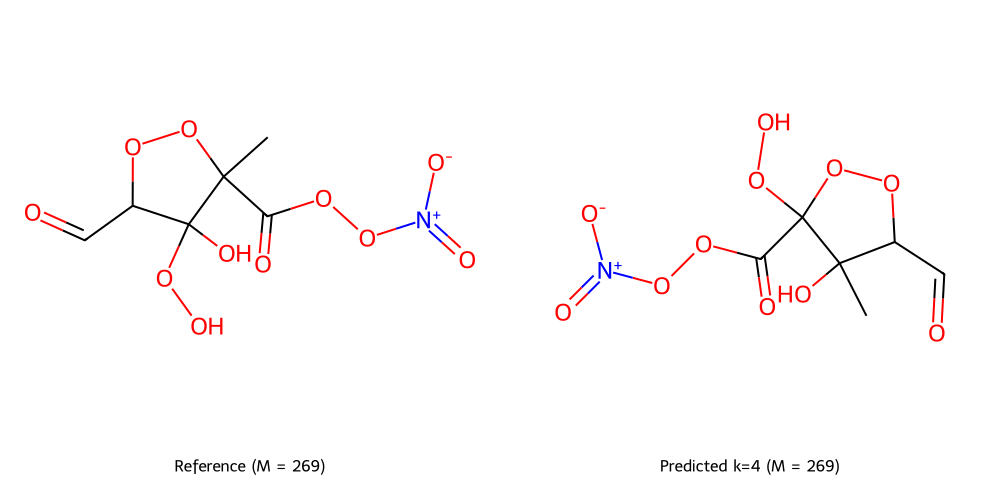

In [386]:
def show_image(im, show_im: bool):
    if show_im: 
        return im
    return None
#mol2 = Chem.RemoveAllHs(next(mols2))
try:
    show_im = True
    mol3 = Chem.RemoveAllHs(next(mols3))
    mol2_idx = next(mols2_idx)
    mol3_idx = next(mols3_idx)
    molwt1, molwt3, = round(ExactMolWt(mol1)), round(ExactMolWt(mol3))
    print(f'{CalcMolFormula(mol1)}, {CalcMolFormula(mol3)}')
    legends = [f'Reference (M = {molwt1})', f'Predicted k={mol3_idx+1} (M = {molwt3})', f'Predicted k={mol3_idx+1} (M = {molwt3})']
    subImgSize = (500, 500)
    im = Draw.MolsToGridImage([mol1, mol3], molsPerRow=2, subImgSize=subImgSize, legends=legends)
except StopIteration:
    mol_idx += 1
    _iterate()
    show_im= False
im = show_image(im, show_im)
im

In [16]:
def create_labeled_mol_image(mol, title_top, title_bottom, img_size=(800, 800)):
    # Draw molecule (slightly smaller to leave space for top/bottom text)
    mol_img = Draw.MolToImage(mol, size=(img_size[0], img_size[1] - 80))

    # New canvas
    canvas = Image.new("RGB", img_size, "white")
    canvas.paste(mol_img, (0, 40))  # vertical offset for top label

    draw = ImageDraw.Draw(canvas)

    font = ImageFont.truetype("arial.ttf", 50)
    font_title = ImageFont.truetype("arial.ttf", 40)

    # Helper to get centered text x-position
    def center_text_x(text):
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        return (img_size[0] - text_width) // 2

    # Draw top and bottom text
    draw.text((20, 30), title_top, fill="black", font=font_title)
    draw.text((center_text_x(title_bottom), img_size[1] - 60), title_bottom, fill="black", font=font)

    return canvas


In [17]:
# Reference molecule
img1 = create_labeled_mol_image(mol1, title_top=mol1_name, title_bottom="Reference")

# Predicted molecule
img2 = create_labeled_mol_image(mol3, title_top='', title_bottom=f"Predicted k={mol3_idx+1}")

# Combine side-by-side
combined_img = Image.new("RGB", (img1.width + img2.width, img1.height), "white")
combined_img.paste(img1, (0, 0))
combined_img.paste(img2, (img1.width, 0))

# Add to picture list
pictures.append(combined_img)

In [18]:
def stack_images_vertically_with_lines(images, line_height=5, line_color="gray"):
    # Add separator lines between each image
    total_height = sum(img.height for img in images) + line_height * (len(images) - 1)
    max_width = max(img.width for img in images)

    final_image = Image.new("RGB", (max_width, total_height), "white")
    
    y_offset = 0
    for idx, img in enumerate(images):
        final_image.paste(img, (0, y_offset))
        y_offset += img.height

        # Draw separator line unless it's the last image
        if idx < len(images) - 1:
            line = Image.new("RGB", (max_width, line_height), line_color)
            final_image.paste(line, (0, y_offset))
            y_offset += line_height

    return final_image

In [19]:
# Stack all combined images vertically
if pictures:
    stack_images_vertically_with_lines(pictures).save("all_comparisons.png")

In [20]:
raise Exception

Exception: 

In [ ]:
# Set up the drawer
drawer = rdMolDraw2D.MolDraw2DCairo(3000, 400)  # width x height
drawer.drawOptions().legendFontSize = 35      # <-- increase font size here


drawer.DrawMolecule(mol1, legend=legends[0])
# Translate the drawing origin to the right for the second molecule
drawer.SetOffset(700, 0)
drawer.DrawMolecule(mol3, legend=legends[1])

drawer.FinishDrawing()
with open('molecules.png', 'wb') as f:
    f.write(drawer.GetDrawingText())

# Load with PIL
img = Image.open('molecules.png')

# Create a white background image
bg = Image.new(img.mode, img.size, (255, 255, 255))

# Calculate difference
diff = ImageChops.difference(img, bg)

# Enhance difference to highlight non-white areas
bbox = diff.getbbox()

if bbox:
    cropped_img = img.crop(bbox)
    cropped_img.show()  # display cropped image
    cropped_img.save('molecules.png')
else:
    print("No non-white area detected; image may already be fully cropped.")

In [ ]:

from rdkit import Chem

# Example list of SMILES
smiles_list = df['SMILES'].values

# Function to extract elements from a SMILES string
def get_elements(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return set()
    return {atom.GetSymbol() for atom in mol.GetAtoms()}

# Apply to list
elements_per_smiles = [get_elements(smi) for smi in smiles_list]

# Optionally get full unique set across all molecules
all_elements = set().union(*elements_per_smiles)

# Print results
for smi, elements in zip(smiles_list, elements_per_smiles):
    print(f"{smi} → {sorted(elements)}")

print("\nAll unique elements across all SMILES:", sorted(all_elements))

KeyboardInterrupt: 

In [ ]:
raise Exception

Exception: 

In [ ]:
morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)

In [ ]:
mols = df['mol'].values
fps = [morgan_generator.GetFingerprint(mol) for mol in tqdm(mols, desc="Computing fingerprints")]

num_dupes = 0
n = len(fps)
for i in tqdm(range(n), desc="Checking for duplicates"):
    for j in range(i + 1, n):
        if TanimotoSimilarity(fps[i], fps[j]) == 1.0:
            num_dupes += 1  

Checking for duplicates:   1%|          | 1593/166434 [03:23<5:51:18,  7.82it/s]


KeyboardInterrupt: 

In [ ]:
print(num_dupes)